## Загрузите и подготовьте данные

In [1]:
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import f1_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
from sklearn.linear_model import LogisticRegression 
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
data.duplicated().sum()

0

<AxesSubplot:xlabel='Tenure'>

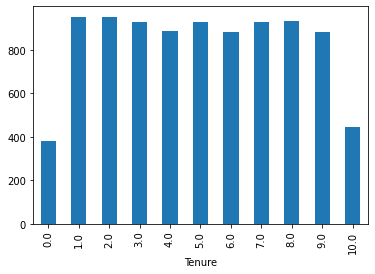

In [6]:
data.groupby('Tenure')['Tenure'].count().plot(kind='bar')

In [7]:
data['Tenure'].median()

5.0

Сразу же становится заметно, что названия столбцов заполнены некорректно, приведем их к змеиному регистру.

В таблице нет дубликатов, но есть пропуски в столбце "Tenure". Этот столбец содержит информацию о том, сколько лет человек является клиентом банка. Пропуски можно заполнить медианным значением, но тогда появится пик на значении 5, что может повлиять на обучение модели. Т.к. значения распределены довольно равномерно, по крайней мере от 1 до 9, нам необходимо заполнить пропуски также равномерно. Сделаем это с помощью заполнения случайной величиной от 0 до 10. 


Что касается признаков, видим, что имеются признаки, которые не несут в себе полезной для обучения модели информации. Необходимо избавиться от столбцов "RowNumber", "CustomerId" и "Surname". Среди оставшихся признаков есть категориальные, что приведет к ошибке при обучении модели. Исправим это с помощью прямого кодирования (OHE), т.к. эта техника работает со всеми моделями машинного обучения. А также необходимо произвести масштабирование количественных признаков, чтобы модель не сочла какие то признаки важнее других.

### Изменение названий столбцов

In [8]:
# избавимся от столбцов
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [9]:
# переименуем столбцы
data = (data.rename(columns = {'CreditScore': 'credit_score', 'Geography': 'geography', 
                      'Gender': 'gender', 'Age': 'age', 'Tenure': 'tenure',
                      'Balance': 'balance', 'NumOfProducts': 'num_of_products',
                      'HasCrCard': 'has_cr_card', 'IsActiveMember': 'is_active_member',
                      'EstimatedSalary': 'estimated_salary', 'Exited': 'exited'}))

In [10]:
data.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

### Заполнение пропусков

In [11]:
# создадим функцию для одной строки,
# которая на вход принимает значения столбца 'tenure'
# если значение не пропущено, возвращает это же значение
# если пропущено, то заполняет его случайным значением от 0 до 10
def random_filling(row):
    tenure = row['tenure']
    if tenure >= 0:
        return tenure
    else:
        return np.random.randint(0, 11)

<AxesSubplot:xlabel='tenure'>

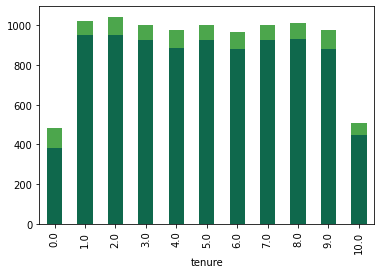

In [12]:
data.groupby('tenure')['tenure'].count().plot(kind='bar', alpha=0.8, color='b')
np.random.seed(42)
data['tenure'] = data.apply(random_filling, axis=1)
data.groupby('tenure')['tenure'].count().plot(kind='bar', alpha=0.7, color='g')

In [13]:
data['tenure'].isna().sum()

0

На графике видно, что пропуски заполнились равномерно.

### Подготовка признаков

In [14]:
# применим прямое кодирование, 
# не угодив при этом в дамми-ловушку
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [15]:
# разобъём данные на обучающую, валидационную и тестовую выборки
target = data_ohe['exited']
features = data_ohe.drop('exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

features_train.shape, features_valid.shape, features_test.shape

((6000, 11), (2000, 11), (2000, 11))

In [16]:
# выделим численные признаки и масштабируем их

numeric = ['credit_score', 'age', 'tenure', 'balance',\
           'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary']

pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])


features_train.shape

(6000, 11)

### Вывод

В этом пункте была произведена подготовка данных: были заполнены пропуски и удалены ненужные столбцы. А также были подготовлены признаки для дальнейшего обучения моделей, произведено кодирование категориальных и масштабирование численных признаков. Были выделены обучающая, валидационная и тестовая выборки.

## Исследуйте баланс классов, обучите модель без учёта дисбаланса.

0    0.7963
1    0.2037
Name: exited, dtype: float64


<AxesSubplot:>

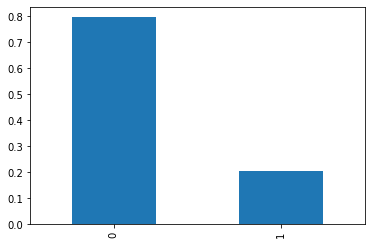

In [17]:
# исследуем целевой признак
# посмотрим, как часто встречается класс «1» или «0»
class_frequency = data['exited'].value_counts(normalize=2)
print(class_frequency)
class_frequency.plot(kind='bar')

Видим, что клиенты уходят в 20% случаев. Наблюдается дисбаланс классов, т.к. соотношение классов далеко от 1:1. Всвязи с этим, для оценки качества прогноза модели будем использовать метрику F1-мера.

### Решающее дерево

In [18]:
best_model_dt = None
best_f1_dt = 0
best_depth_dt = 0
best_auc_roc_dt = 0
for depth in range(1, 16):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dt.fit(features_train, target_train)
    predictions_dt = model_dt.predict(features_valid)
    f1_dt = f1_score(target_valid, predictions_dt)
    probabilities_valid = model_dt.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc_dt = roc_auc_score(target_valid, probabilities_one_valid)
    if f1_dt > best_f1_dt:
        best_model_dt = model_dt
        best_f1_dt = f1_dt
        best_depth_dt = depth
        best_auc_roc_dt = auc_roc_dt

print('F1 наилучшей модели на валидационной выборке:', best_f1_dt)
print('Глубина дерева:', best_depth_dt)
print('AUC ROC', best_auc_roc_dt)

F1 наилучшей модели на валидационной выборке: 0.5705614567526556
Глубина дерева: 6
AUC ROC 0.8169410352107139


### Случайный лес

In [19]:
best_model_rf = None
best_f1_rf = 0
best_depth_rf = 0
best_est_rf = 0
best_auc_roc_rf = 0
for est in range(10, 61, 10):
    for depth in range(1, 16):
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rf.fit(features_train, target_train)
        predictions_rf = model_rf.predict(features_valid)
        f1_rf = f1_score(target_valid, predictions_rf)
        probabilities_valid = model_rf.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc_rf = roc_auc_score(target_valid, probabilities_one_valid)
        if f1_rf > best_f1_rf:
            best_model_rf = model_rf
            best_f1_rf = f1_rf
            best_depth_rf = depth
            best_est_rf = est
            best_auc_roc_rf = auc_roc_rf
            
print('F1 наилучшей модели на валидационной выборке:', best_f1_rf)
print('Глубина дерева:', best_depth_rf)
print('Количество деревьев:', best_est_rf)
print('AUC ROC:', best_auc_roc_rf)

F1 наилучшей модели на валидационной выборке: 0.5896656534954408
Глубина дерева: 13
Количество деревьев: 60
AUC ROC: 0.8402119538589031


### Логистическая регрессия 

In [20]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_train, target_train)
predictions_lr = model_lr.predict(features_valid)
f1_lr = f1_score(target_valid, predictions_lr)
probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_lr = roc_auc_score(target_valid, probabilities_one_valid)
print('F1 модели логистической регрессии на валидационной выборке:', f1_lr)
print('AUC ROC:', auc_roc_lr)

F1 модели логистической регрессии на валидационной выборке: 0.33783783783783783
AUC ROC: 0.7586711146329217


### Вывод

Несмотря на перебор гиперпараметров, наилучшие модели не дотягивают до нужной нам отметки в 0.59 даже на валидационной выборке. На тестовой выборке показатели, как правило еще хуже. Самое высокое значение f1-меры показала модель Случайный лес. Логистическая регрессия показала самые худшие результаты. Это случилось из-за того, что не был учтен дисбаланс классов. Необходимо улучшить метрики применив техники:  взвешивание классов, upsampling и downsampling.

## Улучшите качество модели, учитывая дисбаланс классов

### Техника взвешивания классов

In [21]:
# добавляю аргумент class_weight='balanced' к модели Решающее дерево
best_model_dt = None
best_f1_dt = 0
best_depth_dt = 0
best_auc_roc_dt = 0
for depth in range(1, 16):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model_dt.fit(features_train, target_train)
    predictions_dt = model_dt.predict(features_valid)
    f1_dt = f1_score(target_valid, predictions_dt)
    probabilities_valid = model_dt.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc_dt = roc_auc_score(target_valid, probabilities_one_valid)
    if f1_dt > best_f1_dt:
        best_model_dt = model_dt
        best_f1_dt = f1_dt
        best_depth_dt = depth
        best_auc_roc_dt = auc_roc_dt

print('F1 наилучшей модели на валидационной выборке:', best_f1_dt)
print('AUC ROC:', best_auc_roc_dt)
print('Глубина дерева:', best_depth_dt)

F1 наилучшей модели на валидационной выборке: 0.5963791267305644
AUC ROC: 0.8310244134068074
Глубина дерева: 5


In [22]:
# добавляю аргумент class_weight='balanced' к модели Случаный лес
best_model_rf = None
best_f1_rf = 0
best_depth_rf = 0
best_est_rf = 0
best_auc_roc_rf = 0
for est in range(10, 61, 10):
    for depth in range(1, 16):
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est,\
                                          max_depth=depth, class_weight='balanced')
        model_rf.fit(features_train, target_train)
        predictions_rf = model_rf.predict(features_valid)
        f1_rf = f1_score(target_valid, predictions_rf)
        probabilities_valid = model_rf.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]    
        auc_roc_rf = roc_auc_score(target_valid, probabilities_one_valid)
        if f1_rf > best_f1_rf:
            best_model_rf = model_rf
            best_f1_rf = f1_rf
            best_depth_rf = depth
            best_est_rf = est
            best_auc_roc_rf = auc_roc_rf
            
print('F1 наилучшей модели на валидационной выборке:', best_f1_rf)
print('AUC ROC:', best_auc_roc_rf)
print('Глубина дерева:', best_depth_rf)
print('Количество деревьев:', best_est_rf)

F1 наилучшей модели на валидационной выборке: 0.6313559322033898
AUC ROC: 0.851490905461562
Глубина дерева: 7
Количество деревьев: 40


In [23]:
# добавляю аргумент class_weight='balanced' к модели Логистическая регрессия
model_lr = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_lr.fit(features_train, target_train)
predictions_lr = model_lr.predict(features_valid)
f1_lr = f1_score(target_valid, predictions_lr)
probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_lr = roc_auc_score(target_valid, probabilities_one_valid)
print('F1 модели логистической регрессии на валидационной выборке:', f1_lr)
print('AUC ROC:', auc_roc_lr)

F1 модели логистической регрессии на валидационной выборке: 0.48843187660668386
AUC ROC: 0.7634920970971273


Видим, что метрика f1-мера подросла для всех моделей. Наилучший результат у модели Случайный лес. Это же касается и метрики AUC ROC.

### Upsampling

In [24]:
# посчитаем соотношение классов
len(data[data['exited']==0])//len(data[data['exited']==1])

3

In [25]:
# создадим функицию и получим сэмплы
# соотношение классов 1:3
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)
target_upsampled.value_counts()

0    4804
1    3588
Name: exited, dtype: int64

In [26]:
# применяю upsampling для Решащего дерева

best_model_dt = None
best_f1_dt = 0
best_depth_dt = 0
best_auc_roc_dt = 0
for depth in range(1, 16):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dt.fit(features_upsampled, target_upsampled)
    predictions_dt = model_dt.predict(features_valid)
    f1_dt = f1_score(target_valid, predictions_dt)
    probabilities_valid = model_dt.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc_dt = roc_auc_score(target_valid, probabilities_one_valid)
    if f1_dt > best_f1_dt:
        best_model_dt = model_dt
        best_f1_dt = f1_dt
        best_depth_dt = depth
        best_auc_roc_dt = auc_roc_dt

print('F1 наилучшей модели на валидационной выборке:', best_f1_dt)
print('AUC ROC:', best_auc_roc_dt)
print('Глубина дерева:', best_depth_dt)

F1 наилучшей модели на валидационной выборке: 0.586374695863747
AUC ROC: 0.8229097986317362
Глубина дерева: 5


In [27]:
# применяю upsampling для Случайного леса

best_model_rf = None
best_f1_rf = 0
best_depth_rf = 0
best_est_rf = 0
best_auc_roc_rf = 0
for est in range(10, 61, 10):
    for depth in range(1, 16):
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rf.fit(features_upsampled, target_upsampled)
        predictions_rf = model_rf.predict(features_valid)
        f1_rf = f1_score(target_valid, predictions_rf)
        probabilities_valid = model_rf.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]    
        auc_roc_rf = roc_auc_score(target_valid, probabilities_one_valid)
        if f1_rf > best_f1_rf:
            best_model_rf = model_rf
            best_f1_rf = f1_rf
            best_depth_rf = depth
            best_est_rf = est
            best_auc_roc_rf = auc_roc_rf
            
print('F1 наилучшей модели на валидационной выборке:', best_f1_rf)
print('AUC ROC:', best_auc_roc_rf)
print('Глубина дерева:', best_depth_rf)
print('Количество деревьев:', best_est_rf)

F1 наилучшей модели на валидационной выборке: 0.6473317865429234
AUC ROC: 0.8535256080668285
Глубина дерева: 7
Количество деревьев: 40


In [28]:
# применяю upsampling для Логистической регрессии 

model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_upsampled, target_upsampled)
predictions_lr = model_lr.predict(features_valid)
f1_lr = f1_score(target_valid, predictions_lr)
probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_lr = roc_auc_score(target_valid, probabilities_one_valid)
print('F1 модели логистической регрессии на валидационной выборке:', f1_lr)
print('AUC ROC:', auc_roc_lr)

F1 модели логистической регрессии на валидационной выборке: 0.4985044865403789
AUC ROC: 0.7625530035870046


Модель Решающее дерево показала значение метрики f1-мера хуже, чем при технике взвешивания классов. А вот для модели Слуйчаный лес метрика f1-мера еще подросла, чего не скажешь о метрике AUC ROC (увеличение только в тысячных долях).

### Downsampling

In [42]:
# создадим функцию и получим семплы
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.2)
target_downsampled.value_counts()

1    1196
0     961
Name: exited, dtype: int64

In [30]:
# применяю downsampling для Решающего дерева

best_model_dt = None
best_f1_dt = 0
best_depth_dt = 0
best_auc_roc_dt = 0
for depth in range(1, 16):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dt.fit(features_downsampled, target_downsampled)
    predictions_dt = model_dt.predict(features_valid)
    f1_dt = f1_score(target_valid, predictions_dt)
    probabilities_valid = model_dt.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc_dt = roc_auc_score(target_valid, probabilities_one_valid)
    if f1_dt > best_f1_dt:
        best_model_dt = model_dt
        best_f1_dt = f1_dt
        best_depth_dt = depth
        best_auc_roc_dt = auc_roc_dt

print('F1 наилучшей модели на валидационной выборке:', best_f1_dt)
print('AUC ROC:', best_auc_roc_dt)
print('Глубина дерева:', best_depth_dt)

F1 наилучшей модели на валидационной выборке: 0.5489220563847429
AUC ROC: 0.8181568664218872
Глубина дерева: 5


In [31]:
# применяю downsampling для Случайного леса
            
best_model_rf = None
best_f1_rf = 0
best_depth_rf = 0
best_est_rf = 0
best_auc_roc_rf = 0
for est in range(10, 61, 10):
    for depth in range(1, 16):
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rf.fit(features_downsampled, target_downsampled)
        predictions_rf = model_rf.predict(features_valid)
        f1_rf = f1_score(target_valid, predictions_rf)
        probabilities_valid = model_rf.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]    
        auc_roc_rf = roc_auc_score(target_valid, probabilities_one_valid)
        if f1_rf > best_f1_rf:
            best_model_rf = model_rf
            best_f1_rf = f1_rf
            best_depth_rf = depth
            best_est_rf = est
            best_auc_roc_rf = auc_roc_rf
            
print('F1 наилучшей модели на валидационной выборке:', best_f1_rf)
print('AUC ROC:', best_auc_roc_rf)
print('Глубина дерева:', best_depth_rf)
print('Количество деревьев:', best_est_rf)

F1 наилучшей модели на валидационной выборке: 0.5888689407540395
AUC ROC: 0.838197666329944
Глубина дерева: 4
Количество деревьев: 10


In [32]:
# применяю downsampling для Логистической регрессии

model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_downsampled, target_downsampled)
predictions_lr = model_lr.predict(features_valid)
f1_lr = f1_score(target_valid, predictions_lr)
probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc_lr = roc_auc_score(target_valid, probabilities_one_valid)
print('F1 модели логистической регрессии на валидационной выборке:', f1_lr)
print('AUC ROC:', auc_roc_lr)

F1 модели логистической регрессии на валидационной выборке: 0.4799382716049383
AUC ROC: 0.763068673292241


В данной задаче техника уменьшения выборки показала наихудший результат среди всех техник для борьбы с дисбалансом классов.

### Вывод

В этом пункте был произведен перебор техник для борьбы с дисблансом классов с целью улучшения метрик моделей. А также был сделан подбор гиперпараметров для выявления наилучшей модели. В результате можно выделить модель Случайного леса, обученную на увеличенной выборке, с количеством деревьев 40 и глубиной дерева 7.

## Проведите финальное тестирование

In [33]:
# инициализируем модель
model = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=7)

# обучим на увеличенной выборке
model.fit(features_upsampled, target_upsampled)

# получим предсказания на тестовой выборке
predictions_test = model.predict(features_test)

f1 = f1_score(target_test, predictions_test)
print('F1-мера:', f1)

probabilities_test = model_rf.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]    
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('AUC ROC:', auc_roc)

F1-мера: 0.5995316159250585
AUC ROC: 0.8365548794656041


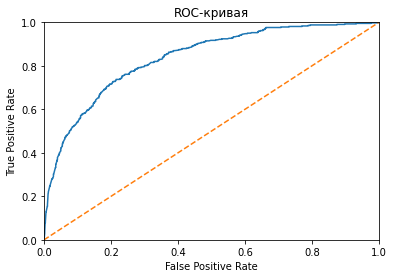

In [34]:
# построим ROC-кривую
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели (выглядит как прямая)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

## Вывод

Была произведена работа по созданию модели для прогнозирования ухода клиентов из банка. На первом этапе были обработаны данные и подготовлены признаки для дальнейшего обучения моделей, произведено кодирование категориальных и масштабирование численных признаков. А также были выделены обучающая, валидационная и тестовая выборки.

В ходе исследования был выявлен дисбаланс классов целевого признака (примерно 80:20). Для оценки качества модели была принята метрика f1-мера и дополонительно расчет метрики AUC ROC. Затем было произведено обучение трех моделей: Решающее дерево, Случайный лес и Логистическая регрессия. Полученные метрики не были достаточно высоки, чтобы выполнить цель исследования.

Для улучшения качества модели было принято решение применить методы борьбы с дисбалансом классов, а именно технику взвешивания классов, увеличение выборки и уменьшение выборки. После применения данных методов качество моделей возросло. Наиболее хорошие результаты показали техники взвешивания классов и увеличение выборки. Лучший результат показала модель Случайный лес с количеством деревьев 40 и глубиной дерева 7, обученная на увеличенной выборке.

На следующем этапе было произведено тестирование лучшей модели на новых данных, в ходе которого были получены метрики:

* F1-мера на тестовой выборке равна 0.599;
* AUC ROC на тестовой выборке равна 0.849.